In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from time import time

from pytorch_lightning.metrics.functional import accuracy

import matplotlib.pyplot as plt

In [2]:
batch_size_train = 32
batch_size_val = 1000
batch_size_test = 1000

In [3]:
device = torch.device("cuda")

In [4]:
# Data Augmentation - add Gaussian noise and random rotation
# to the images from train dataset

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

# load the MNIST dataset
# the global mean and standard deviation of the MNIST dataset - 0.1307 and 0.3081 
# accordingly are used for data normalization 
# apply data augmentation

train_dataset = torchvision.datasets.MNIST('/files/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               torchvision.transforms.RandomRotation(degrees=(30)),
                               AddGaussianNoise(0., 0.25)
                             ]))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# split train_dataset into train and validation datasets 
# create corresponding instances of DataLoader class

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                         [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

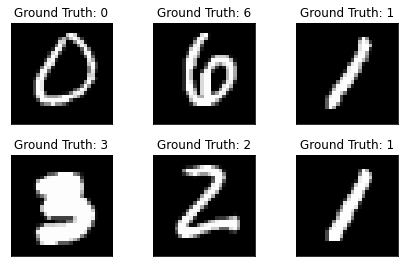

In [5]:
# print out some examples of original MNIST images 

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

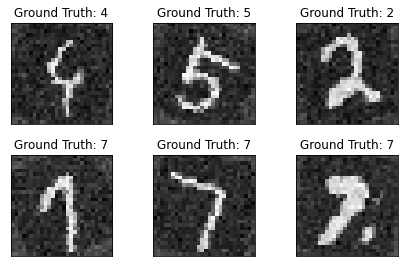

In [6]:
# print out some examples of augmented MNIST images 

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [7]:
# basically a function that runs a training process for the neural network

def train(model, train_loader, Tikhonov=False, scheduler=False, save_best_weights=False):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
     # to reduce learning rate on plateau the corresponding scheduler is applied
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
        
    time0 = time()
    
    epochs = 10

    epochs_loss = [0]*epochs
    epochs_accuracy = [0]*epochs

    train_losses = []
    train_counter = []
    log_interval = 15

    for e in range(epochs):
        running_loss = 0
        running_accuracy = 0
    
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
        
            output = model(images)
            
            loss = loss_fn(output, labels)
        
            loss.backward()
            
            optimizer.step()
        
            running_loss += loss.item()
        
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)
            
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + (e*len(train_loader.dataset)))         
    
        val_loss, val_acc = validate(model, val_loader)
        scheduler.step(val_loss)
        
        epochs_loss[e] = running_loss/len(train_loader)
        epochs_accuracy[e] = running_accuracy/len(train_loader)
        
        print("Epoch {}:\n Training loss: {} - Training accuracy: {} \n Validation loss: {} - Validation accuracy: {}"
              .format(e, epochs_loss[e], epochs_accuracy[e], val_loss, val_acc))
        
    print("\nTraining Time (minutes) =",(time()-time0)/60)
    
    fig, (ax1, ax2) = plt.subplots(1,2)

    fig.set_figwidth(20)
    fig.set_figheight(7)

    line1, = ax1.plot(range(epochs), epochs_loss)
    ax2.plot(train_counter, train_losses)

    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax2.set(xlabel="Number of training examples seen", ylabel="Loss")


In [8]:
# this function calculates a loss value and prediction accuracy
# on the validation dataset

def validate (model, val_loader):
    
    running_loss = 0
    running_accuracy = 0
    
    for images, labels in val_loader:
        with torch.no_grad():
            images = images.view(images.shape[0], -1)
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            
            running_loss += loss_fn(output, labels)
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)
            
    running_loss /= len(val_loader)
    running_accuracy /= len(val_loader)
    
    return (running_loss, running_accuracy)

In [9]:
# define the model

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Epoch 0:
 Training loss: 0.5581777571001575 - Training accuracy: 0.8316338658332825 
 Validation loss: 0.32295164465904236 - Validation accuracy: 0.8997001051902771
Epoch 1:
 Training loss: 0.23808937796504162 - Training accuracy: 0.9270633459091187 
 Validation loss: 0.20611904561519623 - Validation accuracy: 0.9392000436782837
Epoch 2:
 Training loss: 0.1797603620305629 - Training accuracy: 0.9445977210998535 
 Validation loss: 0.1731063723564148 - Validation accuracy: 0.9464001059532166
Epoch 3:
 Training loss: 0.14820957947784577 - Training accuracy: 0.954614520072937 
 Validation loss: 0.1463160216808319 - Validation accuracy: 0.9562000632286072
Epoch 4:
 Training loss: 0.13294224423354567 - Training accuracy: 0.9588931798934937 
 Validation loss: 0.1350739300251007 - Validation accuracy: 0.9588000178337097
Epoch 5:
 Training loss: 0.11708706308150889 - Training accuracy: 0.9641314744949341 
 Validation loss: 0.12464308738708496 - Validation accuracy: 0.9621000289916992
Epoch 6:
 

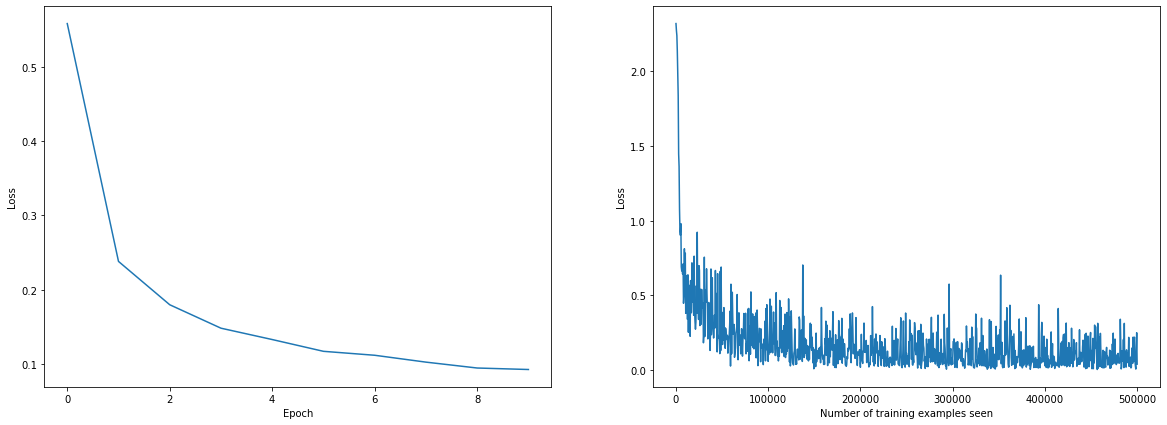

In [11]:
# create a neural net and define a loss function

model = Model(28*28)
model.to(device)

loss_fn = nn.CrossEntropyLoss()

# train the model    

train(model, train_loader)

# appraise the model performance on the unchanged test dataset

loss, acc = validate(model, test_loader)
print("Test loss: {} - Test accuracy: {}".format(loss, acc))